<a href="https://colab.research.google.com/github/19PA1A0495/defect_detection/blob/main/metaldefects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import os
import re
import scipy.misc
from PIL import Image

In [ ]:
train_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/train'
val_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/valid'
test_dir='/content/drive/MyDrive/NEU Metal Surface Defects Data/test'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("Train Direcorty: ",os.listdir('/content/drive/MyDrive/NEU Metal Surface Defects Data/train'))
print("Test Direcorty: ",os.listdir('/content/drive/MyDrive/NEU Metal Surface Defects Data/test'))
print("Validation Direcorty: ",os.listdir('/content/drive/MyDrive/NEU Metal Surface Defects Data/valid'))

Train Direcorty:  ['Pitted', 'Scratches', 'Rolled', 'Patches', 'Inclusion', 'Crazing']
Test Direcorty:  ['Inclusion', 'Crazing', 'Scratches', 'Pitted', 'Patches', 'Rolled']
Validation Direcorty:  ['Pitted', 'Crazing', 'Rolled', 'Inclusion', 'Patches', 'Scratches']


In [ ]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 274
Testing Inclusion data: 12
Validation Inclusion data: 12


In [ ]:
def show(img, figsize=(10, 10), title="Image"):
    figure=plt.figure(figsize=figsize)
    
    plt.imshow(img)
    plt.show()

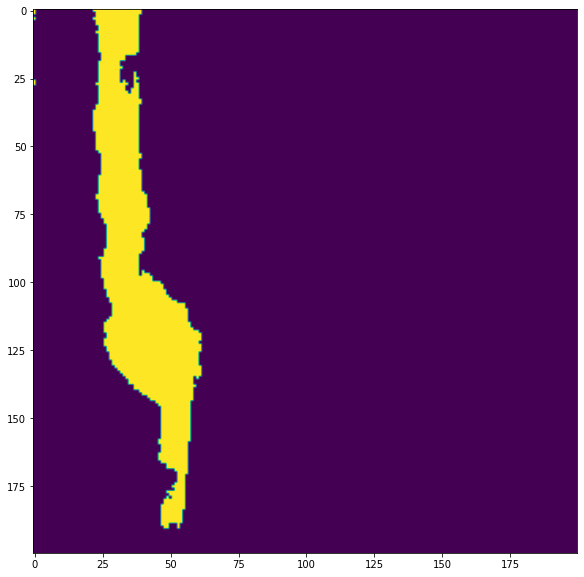

array([[  1,   1],
       [ 21,   0],
       [ 18,   1],
       [160,   0],
       [  1,   1],
       [ 22,   0],
       [ 17,   1],
       [183,   0],
       [ 16,   1],
       [161,   0],
       [  1,   1],
       [ 21,   0],
       [ 17,   1],
       [184,   0],
       [ 16,   1],
       [184,   0],
       [ 16,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [184,   0],
       [ 16,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [185,   0],
       [ 15,   1],
       [186,   0],
       [ 13,   1],
       [187,   0],
       [  9,   1],
       [191,   0],
       [  9,   1],
       [190,   0],
       [  8,   1],
       [192,   0],
       [  8,   1],
       [192,   0],
       [  9,   1],
       [191,   0],
       [  8,   1],
       [192,   0],
       [  8,

In [ ]:
def RLE_encoding(img, bits=8,  binary=True, view=True):
    """
    img: Grayscale img.
    bits: what will be the maximum run length? 2^bits       
    """
    if binary:
        ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if view:
        show(img)

    encoded = []
    shape=img.shape
    count = 0
    prev = None
    fimg = img.flatten()
    th=127
    for pixel in fimg:
        if binary:
            if pixel<th:
                pixel=0
            else:
                pixel=1
        if prev==None:
            prev = pixel
            count+=1
        else:
            if prev!=pixel:
                encoded.append((count, prev))
                prev=pixel
                count=1
            else:
                if count<(2**bits)-1:
                    count+=1
                else:
                    encoded.append((count, prev))
                    prev=pixel
                    count=1
    encoded.append((count, prev))
    
    return np.array(encoded)
fpath="/content/drive/MyDrive/NEU Metal Surface Defects Data/train/Scratches/Sc_122.bmp"
img = cv2.imread(fpath, 0)
shape=img.shape
encoded = RLE_encoding(img, bits=8)
encoded

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1650 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 49, 49, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 128)      0

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
165/165 [==============================] - 517s 3s/step - loss: 1.7921 - accuracy: 0.3606 - val_loss: 0.9325 - val_accuracy: 0.7083
Epoch 2/20
165/165 [==============================] - 105s 636ms/step - loss: 0.9583 - accuracy: 0.6745 - val_loss: 0.4451 - val_accuracy: 0.9028
Epoch 3/20
165/165 [==============================] - 105s 635ms/step - loss: 0.6706 - accuracy: 0.7897 - val_loss: 0.2311 - val_accuracy: 0.9444
Epoch 4/20
165/165 [==============================] - 104s 631ms/step - loss: 0.5301 - accuracy: 0.8273 - val_loss: 0.7513 - val_accuracy: 0.9028
Epoch 5/20
165/165 [==============================] - 104s 631ms/step - loss: 0.5108 - accuracy: 0.8418 - val_loss: 0.2449 - val_accuracy: 0.9583
Epoch 6/20
165/165 [==============================] - 104s 631ms/step - loss: 0.4142 - accuracy: 0.8655 - val_loss: 0.4412 - val_accuracy: 0.8750
Epoch 7/20
165/165 [==============================] - 104s 631ms/step - loss: 0.5026 - accuracy: 0.8752 - val_loss: 0.3761 - va

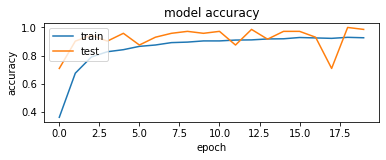

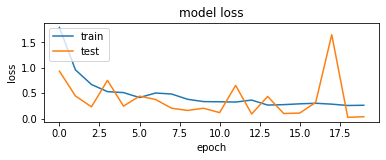

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [ ]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

test_dir = '/content/drive/MyDrive/NEU Metal Surface Defects Data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [ ]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [ ]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [ ]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [ ]:
x_test = x_test.astype('float32')/255

2 2
5 5
3 3
4 4
4 4
4 4
2 2
0 0
2 2
4 4
0 0
0 0
0 0
4 4
4 4
2 2


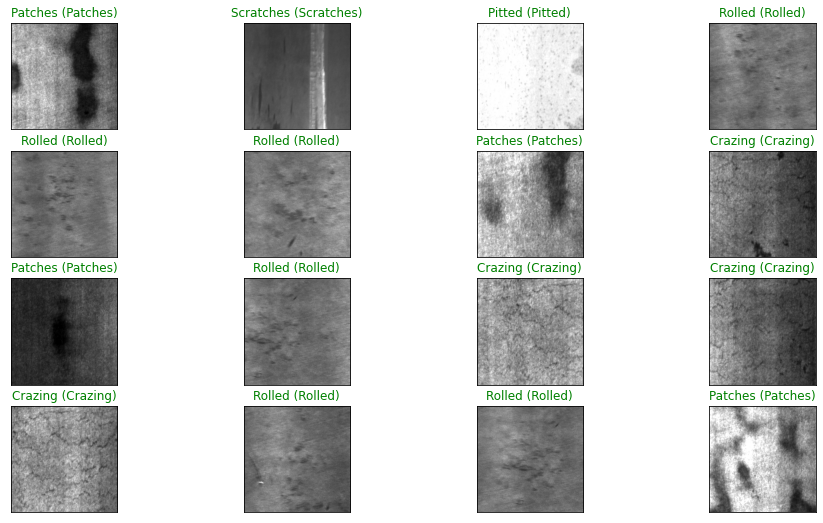

In [ ]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    print(pred_idx,true_idx)
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

    
